In [28]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from IPython.display import display, HTML
from pdpbox import pdp, info_plots #for partial plots
from sklearn.externals import joblib


scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro':'f1_macro'}


title = 'feature_select35_testsize0.3'
KFOLD = 10
N_JOBS = 10


def preprocess(countpath, testsize = 0.2):
    x = pd.read_csv('%s' % countpath, index_col=0).T

    # get feature names
    featurenames = np.array(x.index)

    # get label names
    x = x.T
    y = list(np.array(x.index))
    label = sorted(list(set(y)), key = y.index)
    
    df = x
    df['target'] = y

    for classname in label:
        count_temp = len(df[df.target == classname])
        print("Proportion of family {0}: {1:.2f}%".format(classname, (count_temp / (len(df.target)) * 100)))


    y = df.target.values
    x= df.drop(['target'], axis=1)
    
#     x = x.drop(['A', 'C', 'G', 'U'], axis = 1)
    x = (x - np.min(x)) / (np.max(x) - np.min(x)).values
    
    # Normalize
#     x= x.apply(lambda x :(x-np.min(x))/(np.max(x)-np.min(x)))
    
    x = x.dropna(axis=1, how='any')  # drop all rows that have any NaN value
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = testsize, random_state = 1)

    return x_train, y_train, x_test, y_test, featurenames, label, df


def heat_norm_col(label, featurenames, x_train, counting):
    heat = pd.DataFrame(0, index=np.arange(len(label)), columns=np.arange(featurenames.size))
    heat.index = label
    heat.columns = featurenames
    for i in range(0, len(x_train.index)):
        for j in range(0, len(x_train.columns)):
            heat.loc[x_train.index[i], x_train.columns[j]] = heat.loc[x_train.index[i], x_train.columns[j]] + x_train.iloc[i, j]


    heat_norm = heat
    for i in range(0, len(heat_norm.index)):
        for j in range(0, len(heat_norm.columns)):
            heat_norm.iloc[i, j] = heat_norm.iloc[i, j] / counting[heat_norm.index[i]]

    fig, ax = plt.subplots(figsize=(10,15), dpi = 220)         # Sample figsize in inches
    # Now if we normalize it by column:
    heat_norm_col = heat_norm
    heat_norm_col=(heat_norm_col-heat_norm_col.mean())/heat_norm_col.std()

    return heat_norm_col


def plot_conusion_matrix(model,balance = 'balanced', cmap = plt.cm.Blues, normalize = True):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    confusion = confusion_matrix(y_test, pred)

    ax = plot_con_matrix(confusion, label, normalize=normalize, title = 'Confusion matrix, with normalization of %s %s' % (balance, model) , cmap = cmap)

    plt.show()
    plt.savefig('./Prediction_output_%s/confusion_matrix_%s.png' % (title, model), format='png')


def plot_feature_distribution_heatmap(heat_norm_col,label, cmp = plt.cm.Blues):
    
    ax = plot_con_matrix(heat_norm_col.T, label, normalize = False, title = 'Normalized feature distribution of every family', cmap = cmp)
    plt.show()
    plt.savefig('./Prediction_output_%s/feature_distribution_%s.png' % (title, model), format='png')

    
def plot_con_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    SMALL_SIZE = 9
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 19

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
    
    fig, ax = plt.subplots(figsize = (16, 12), dpi = 330)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
          )
    
    fig.suptitle('%s' % title, fontsize=BIGGER_SIZE)    
    plt.xlabel('Predicted Family', fontsize=MEDIUM_SIZE)
    plt.ylabel('True Family', fontsize=MEDIUM_SIZE)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Adjust the space between ticks and label
    ax.tick_params(axis='both', which='major', pad=5)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0.01:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return ax


def counting(label, y_train):
    counting = {}
    for i in label:
        count = 0
        for j in y_train:
            if i == j:
                count = count+1        
        counting[i] = count
    print(counting)
    
    return counting


def smote_dict(label, counting):
    dict = {}
    for i in label:
        if counting[i] > 1000:
            dict[i] = counting[i]
        elif counting[i] > 700:
            dict[i] = counting[i] * 2
        elif counting[i] > 500:
            dict[i] = counting[i] * 3
        elif counting[i] > 200:
            dict[i] = counting[i] * 5
        else:
            dict[i] = counting[i] * 10
    print(dict)
    return dict


def calcu_metrix(scores):
    return (np.mean(scores['test_f1_macro']) * 0.6 + np.mean(scores['test_prec_macro'])*0.2 + np.mean(scores['test_rec_macro'])* 0.2)


def print_report(name, model, x_test, y_test):
    
    model_pred = model.predict(x_test)
    
    # f1 score
    print("f1 score of {0}: {1:.3f}".format(name, f1_score(y_test,model_pred, average = 'macro')))
    # 模型评估报告
    report = classification_report(y_test, model_pred, target_names= label, output_dict=True)
    
    dataframe = pd.DataFrame(report).transpose()
    dataframe.to_csv('./Prediction_output_%s/Classification_report/%s_%s.csv' % (title, title, name), index = False)

    print("Classification report of {0}: \n{1}".format(name, classification_report(y_test, model_pred,
                                            target_names= label, digits = 3)))


def pltROC(knn, svm, random, boost, mlp, nb, x_train, y_trian, x_test, y_test, balance = 'balanced'):

    knn.fit(x_train, y_train)
    svm.fit(x_train, y_train)
    nb.fit(x_train, y_train)
    boost.fit(x_train, y_train)
    random.fit(x_train, y_train)
    mlp.fit(x_train, y_train)

    d = {knn: 'KNN', svm: 'SVM', nb: 'Naive_Bayes', boost: 'Gradient-boosting', random: 'Random forest', mlp:'Neural Network'}
    # model.predict_proba(x_test)[:,1]
    # y_test.values
    plt.figure(figsize=(24, 16))
    fig, ax = plt.subplots()
    # ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".4")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 10
    plt.title('ROC curve for cancer classifier with the feature selecting \nmethod of %s' % c[count])
    # plt.subplots_adjust(wspace=2, hspace=1, top = 1)
    plt.xlabel("FPR")
    plt.ylabel("TPR(recall)")
    plt.grid(True)
    for model in d:
        proba_rf = model.predict_proba(x_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, proba_rf)
        close_default_rf = np.argmin(np.abs(thresholds - 0.5))
        plt.plot(fpr, tpr, label='ROC Curve of %s' % d[model] + '(AUC = {:.2f})'.format(roc_auc_score(y_test, proba_rf)))
        plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'o', markersize=10, fillstyle="none", c='k', mew=2)
    plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'o', label = 'Thresholds 0.5 RF', markersize=10, fillstyle="none", c='k', mew=2)
    fig.tight_layout()
    plt.legend(loc=4)
    plt.savefig("../Prediction_output_%s/AUC_%s.png" % (title, balance), dpi = 300)
    plt.show()
    pass

In [29]:
# KNN Model
def KNN(x_train, y_train, x_test, y_test, strategy):

    # try ro find best k value
    best = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5), KNeighborsClassifier(n_neighbors=6))
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5, sampling_strategy = strategy), KNeighborsClassifier(n_neighbors=i))  # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))

    
    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_iteration.png" % title)
    plt.show()
    print("Maximum KNN Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    
    print_report('knn', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_cross_validation_score.csv' % title, index=True)

    return best

def KNN_im(x_train, y_train, x_test, y_test):

    # try ro find best k value
    best = KNeighborsClassifier(n_neighbors=6)
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 = KNeighborsClassifier(n_neighbors=i)  # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))
        

    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_im_iteration.png" % title)
    plt.show()

    print("Maximum KNN_im Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    print_report('knn_im', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_im_cross_validation_score.csv' % title, index=True)

 
    return best

In [30]:
def svm(x_train, y_train,x_test, y_test, strategy):
    
    best = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), SVC(cache_size=4096, kernel='linear'))
    best_metrix = 0
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), SVC(cache_size=4096, kernel='%s' % i, probability = True, class_weight = 'balanced'))
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))
        
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))
    
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_cross_validation_score.csv' % title, index=True)
    print_report('svm', best, x_test, y_test)

    return best

def svm_im(x_train, y_train,x_test, y_test):

    best = SVC(cache_size=4096, kernel='linear')
    best_metrix = 0
    
    # try to find the best kernel
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = SVC(cache_size=4096, kernel='%s' % i, probability = True)
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))


    plt.title('Various kernels of SVM algorithms')
    plt.plot([x[0] for x in scoreList], [x[1] for x in scoreList])
    plt.xticks([x[0] for x in scoreList])
    plt.xlabel("Kernel")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/svm_im_kernel.png" % title)
    plt.show()
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))

    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_im_cross_validation_score.csv' % title, index=True)
    print_report('svm_im', best, x_test, y_test)

    return best

In [31]:
def random_forest(x_train, y_train, x_test, y_test, strategy, class_weight = None):
    
    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_features': [50],
                   'randomforestclassifier__max_depth': [20]}]

    best = make_pipeline(SMOTE(random_state = 1, sampling_strategy = strategy), RandomForestClassifier(n_jobs=10, n_estimators = 1000, max_depth = 20, class_weight = class_weight))
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     best_scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
    best.fit(x_train, y_train)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/svm_im_cross_validation_score.csv', index=True)
    print_report('random_forest', best, x_test, y_test)

    return best

def random_forest_im(x_train, y_train, x_test, y_test, class_weight = None):

    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    best_tested_param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_features': [50],
                   'randomforestclassifier__max_depth': [20]}]

    best = RandomForestClassifier(n_jobs=10, n_estimators = 1000, max_depth = 20, class_weight = class_weight)
    best.fit(x_train, y_train)
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
#     print("parameters: ", grid_search.best_params_)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/random_forest_im_cross_validation_score.csv', index=True)
    print_report('random_forest_im', best, x_test, y_test)
    
    return best

In [39]:
def mlp(x_train, y_train, x_test, y_test, strategy):
    mlp = make_pipeline(SMOTE(random_state = 1, sampling_strategy = strategy), MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=200, alpha=0.0001,
                     solver='adam', verbose = 10, tol=0.00001))
    mlp.fit(x_train, y_train)
    print("Accuracy of mlp model is {:.3f}".format(mlp.score(x_test, y_test)))
    proba = mlp.predict_proba(x_test)
    # log_proba = mlp.predict_log_proba(x_test)
    print(mlp.predict(x_test))
    pred_mlp = mlp.predict(x_test)
    print((pred_mlp == y_test).sum() / y_test.size)
    
    print_report('mlp', mlp, x_test, y_test)
    return mlp

def mlp_im(x_train, y_train, x_test, y_test):
    mlp_im = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=200, alpha=0.0001,
                     solver='adam', verbose=10, tol=0.00001)
    mlp_im.fit(x_train, y_train)
    print("Accuracy of mlp_im imbalance model is {:.3f}".format(mlp_im.score(x_test, y_test)))
    proba = mlp_im.predict_proba(x_test)
    # log_proba = mlp_im.predict_log_proba(x_test)
    print(mlp_im.predict(x_test))
    pred_mlp_im = mlp_im.predict(x_test)
    print((pred_mlp_im == y_test).sum() / y_test.size)

    print_report('mlp_im', mlp_im, x_test, y_test)
    return mlp_im

In [6]:
def naive_bayes(x_train, y_train, x_test, y_test, strategy):
    nb = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), GaussianNB(var_smoothing=1e-16))
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test,y_test)*100))

    print_report('nb', nb, x_test, y_test)
    
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

def naive_bayes_im(x_train, y_train, x_test, y_test):
    nb = GaussianNB(var_smoothing=1e-16)
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test, y_test)*100))

    print_report('nb_im', nb, x_test, y_test)
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

In [7]:
def gradient_boosting(x_train, y_train, x_test, y_test, strategy):


    # 网格搜索算法查询最优参数（n_estimators 树个数；learning_rate 学习率； max_depth 树深度 ）
    # params_gbrt = [{
    #     'gradientboostingclassifier__n_estimators':[500,1000,2000],
    #     'gradientboostingclassifier__learning_rate':[0.01,0.1,0.05],
    #     'gradientboostingclassifier__max_depth':[7, 9, 11]
    # }]

    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 13
    }

    # gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=10)
    # gbrt_grid.fit(x_train, y_train)
    # #gbrt.fit(x_train, y_train)

    # print('Report of gradient_boosting:\n')
    # print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
    # print("Best parameters: ", gbrt_grid.best_params_)
    # print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
    # print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

    ## 使用gbrt的最优参数构建模型 并评估模型性能
    # best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = make_pipeline(SMOTE(random_state = 1, sampling_strategy = dict), GradientBoostingClassifier(**params_gbrt))
    gbrt_model.fit(x_train, y_train)
    
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print_report('gb', gbrt_model, x_test, y_test)

    return gbrt_model

def gradient_boosting_im(x_train, y_train, x_test, y_test):
    
    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 13
    }

#     gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=5)
#     gbrt_grid.fit(x_train, y_train)
    #gbrt.fit(x_train, y_train)

#     print('Report of gradient_boosting:\n')
#     print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
#     print("Best parameters: ", gbrt_grid.best_params_)
#     print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
#     print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

#     ## 使用gbrt的最优参数构建模型 并评估模型性能
#     best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = GradientBoostingClassifier(**params_gbrt)
    gbrt_model.fit(x_train, y_train)
    
#     scores = cross_validate(gbrt_model, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
    print("Accuracy on train set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))

    print_report('gb_im', gbrt_model, x_test, y_test)

    return gbrt_model    # 梯度提升回归树  GBRT

In [12]:
weight = {}
for i in label:
    if i == 'RF00168' or i == 'RF00167':
        weight[i] = 7
    elif i == 'RF01054' or i == 'RF00522':
        weight[i] = 150
    elif i == 'RF00634' or i == 'RF00521' or i == 'RF00234':
        weight[i] = 30
    elif i == 'RF01055' or i == 'RF01057' or i == 'RF01063':
        weight[i] = 15
    elif i == 'RF00050' or i == 'RF00162' or i == 'RF01051' or i == 'RF00162':
        weight[i] = 3
    else:
        weight[i] = 1

In [11]:
if __name__ == '__main__':
    countpath = './selected_35.csv'

    x_train, y_train, x_test, y_test, featurenames, label, dataframe = preprocess(countpath, 0.3)

    count = counting(label, y_train)
    dict = smote_dict(label, count)
#     heat_norm = heat_norm_col(label, featurenames, x_train, count)
    

Proportion of family RF00050: 7.48%
Proportion of family RF00059: 22.34%
Proportion of family RF00162: 7.67%
Proportion of family RF00167: 5.02%
Proportion of family RF00168: 2.11%
Proportion of family RF00174: 26.48%
Proportion of family RF00234: 1.70%
Proportion of family RF00380: 1.34%
Proportion of family RF00504: 13.13%
Proportion of family RF00521: 1.03%
Proportion of family RF00522: 0.72%
Proportion of family RF00634: 1.33%
Proportion of family RF01051: 6.30%
Proportion of family RF01054: 0.24%
Proportion of family RF01055: 1.87%
Proportion of family RF01057: 1.22%
{'RF00050': 836, 'RF00059': 2519, 'RF00162': 879, 'RF00167': 570, 'RF00168': 241, 'RF00174': 3016, 'RF00234': 200, 'RF00380': 151, 'RF00504': 1481, 'RF00521': 109, 'RF00522': 77, 'RF00634': 149, 'RF01051': 708, 'RF01054': 32, 'RF01055': 221, 'RF01057': 139}
{'RF00050': 1672, 'RF00059': 2519, 'RF00162': 1758, 'RF00167': 1710, 'RF00168': 1205, 'RF00174': 3016, 'RF00234': 2000, 'RF00380': 1510, 'RF00504': 1481, 'RF00521'

In [19]:
joblib.dump(knn, './Model/knn.pkl')

['./Model/knn.pkl']

In [20]:
knn_new = joblib.load('./Model/knn.pkl')

In [21]:
knn.score(x_test, y_test)

0.7263179571663921

In [26]:
model = RandomForestClassifier(n_jobs=48, n_estimators = 1000, max_depth = 20, class_weight = weight)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True,
                       class_weight={'RF00050': 3, 'RF00059': 1, 'RF00162': 3,
                                     'RF00167': 7, 'RF00168': 7, 'RF00174': 1,
                                     'RF00234': 30, 'RF00380': 1, 'RF00504': 1,
                                     'RF00521': 30, 'RF00522': 150,
                                     'RF00634': 30, 'RF01051': 3,
                                     'RF01054': 150, 'RF01055': 15,
                                     'RF01057': 15},
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=48, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [13]:
model

RandomForestClassifier(bootstrap=True,
                       class_weight={'RF00050': 3, 'RF00059': 1, 'RF00162': 3,
                                     'RF00167': 7, 'RF00168': 7, 'RF00174': 1,
                                     'RF00234': 30, 'RF00380': 1, 'RF00504': 1,
                                     'RF00521': 30, 'RF00522': 150,
                                     'RF00634': 30, 'RF01051': 3,
                                     'RF01054': 150, 'RF01055': 15,
                                     'RF01057': 15},
                       criterion='gini', max_depth=20, max_features=40,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=48, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [27]:
perm = PermutationImportance(model).fit(x_test, y_test)

In [28]:
eli5.show_weights(perm, feature_names = featurenames, top = 35)

Weight,Feature
0.0395 ± 0.0038,GA
0.0268 ± 0.0033,A
0.0246 ± 0.0036,AG
0.0210 ± 0.0021,CUG
0.0189 ± 0.0011,G
0.0186 ± 0.0053,U
0.0180 ± 0.0021,C
0.0178 ± 0.0038,CC
0.0168 ± 0.0015,UCC
0.0160 ± 0.0020,GGG


In [29]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(perm, threshold=0.0012, prefit=True)

In [30]:
x_train = sel.transform(x_train)

In [31]:
x_test = sel.transform(x_test)

In [32]:
x_test

array([[0.29      , 0.41904762, 0.45535714, ..., 0.        , 0.        ,
        0.        ],
       [0.16      , 0.22857143, 0.29464286, ..., 0.        , 0.        ,
        0.16666667],
       [0.22      , 0.14285714, 0.16964286, ..., 0.2       , 0.4       ,
        0.        ],
       ...,
       [0.23      , 0.25714286, 0.28571429, ..., 0.        , 0.        ,
        0.        ],
       [0.23      , 0.19047619, 0.21428571, ..., 0.2       , 0.        ,
        0.        ],
       [0.3       , 0.08571429, 0.16071429, ..., 0.        , 0.        ,
        0.16666667]])

In [52]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

NameError: name 'model' is not defined

In [1]:
shap.summary_plot(shap_values[1], x_test, plot_type="bar")

NameError: name 'shap' is not defined

Confusion matrix, without normalization


KeyError: (0, 0)

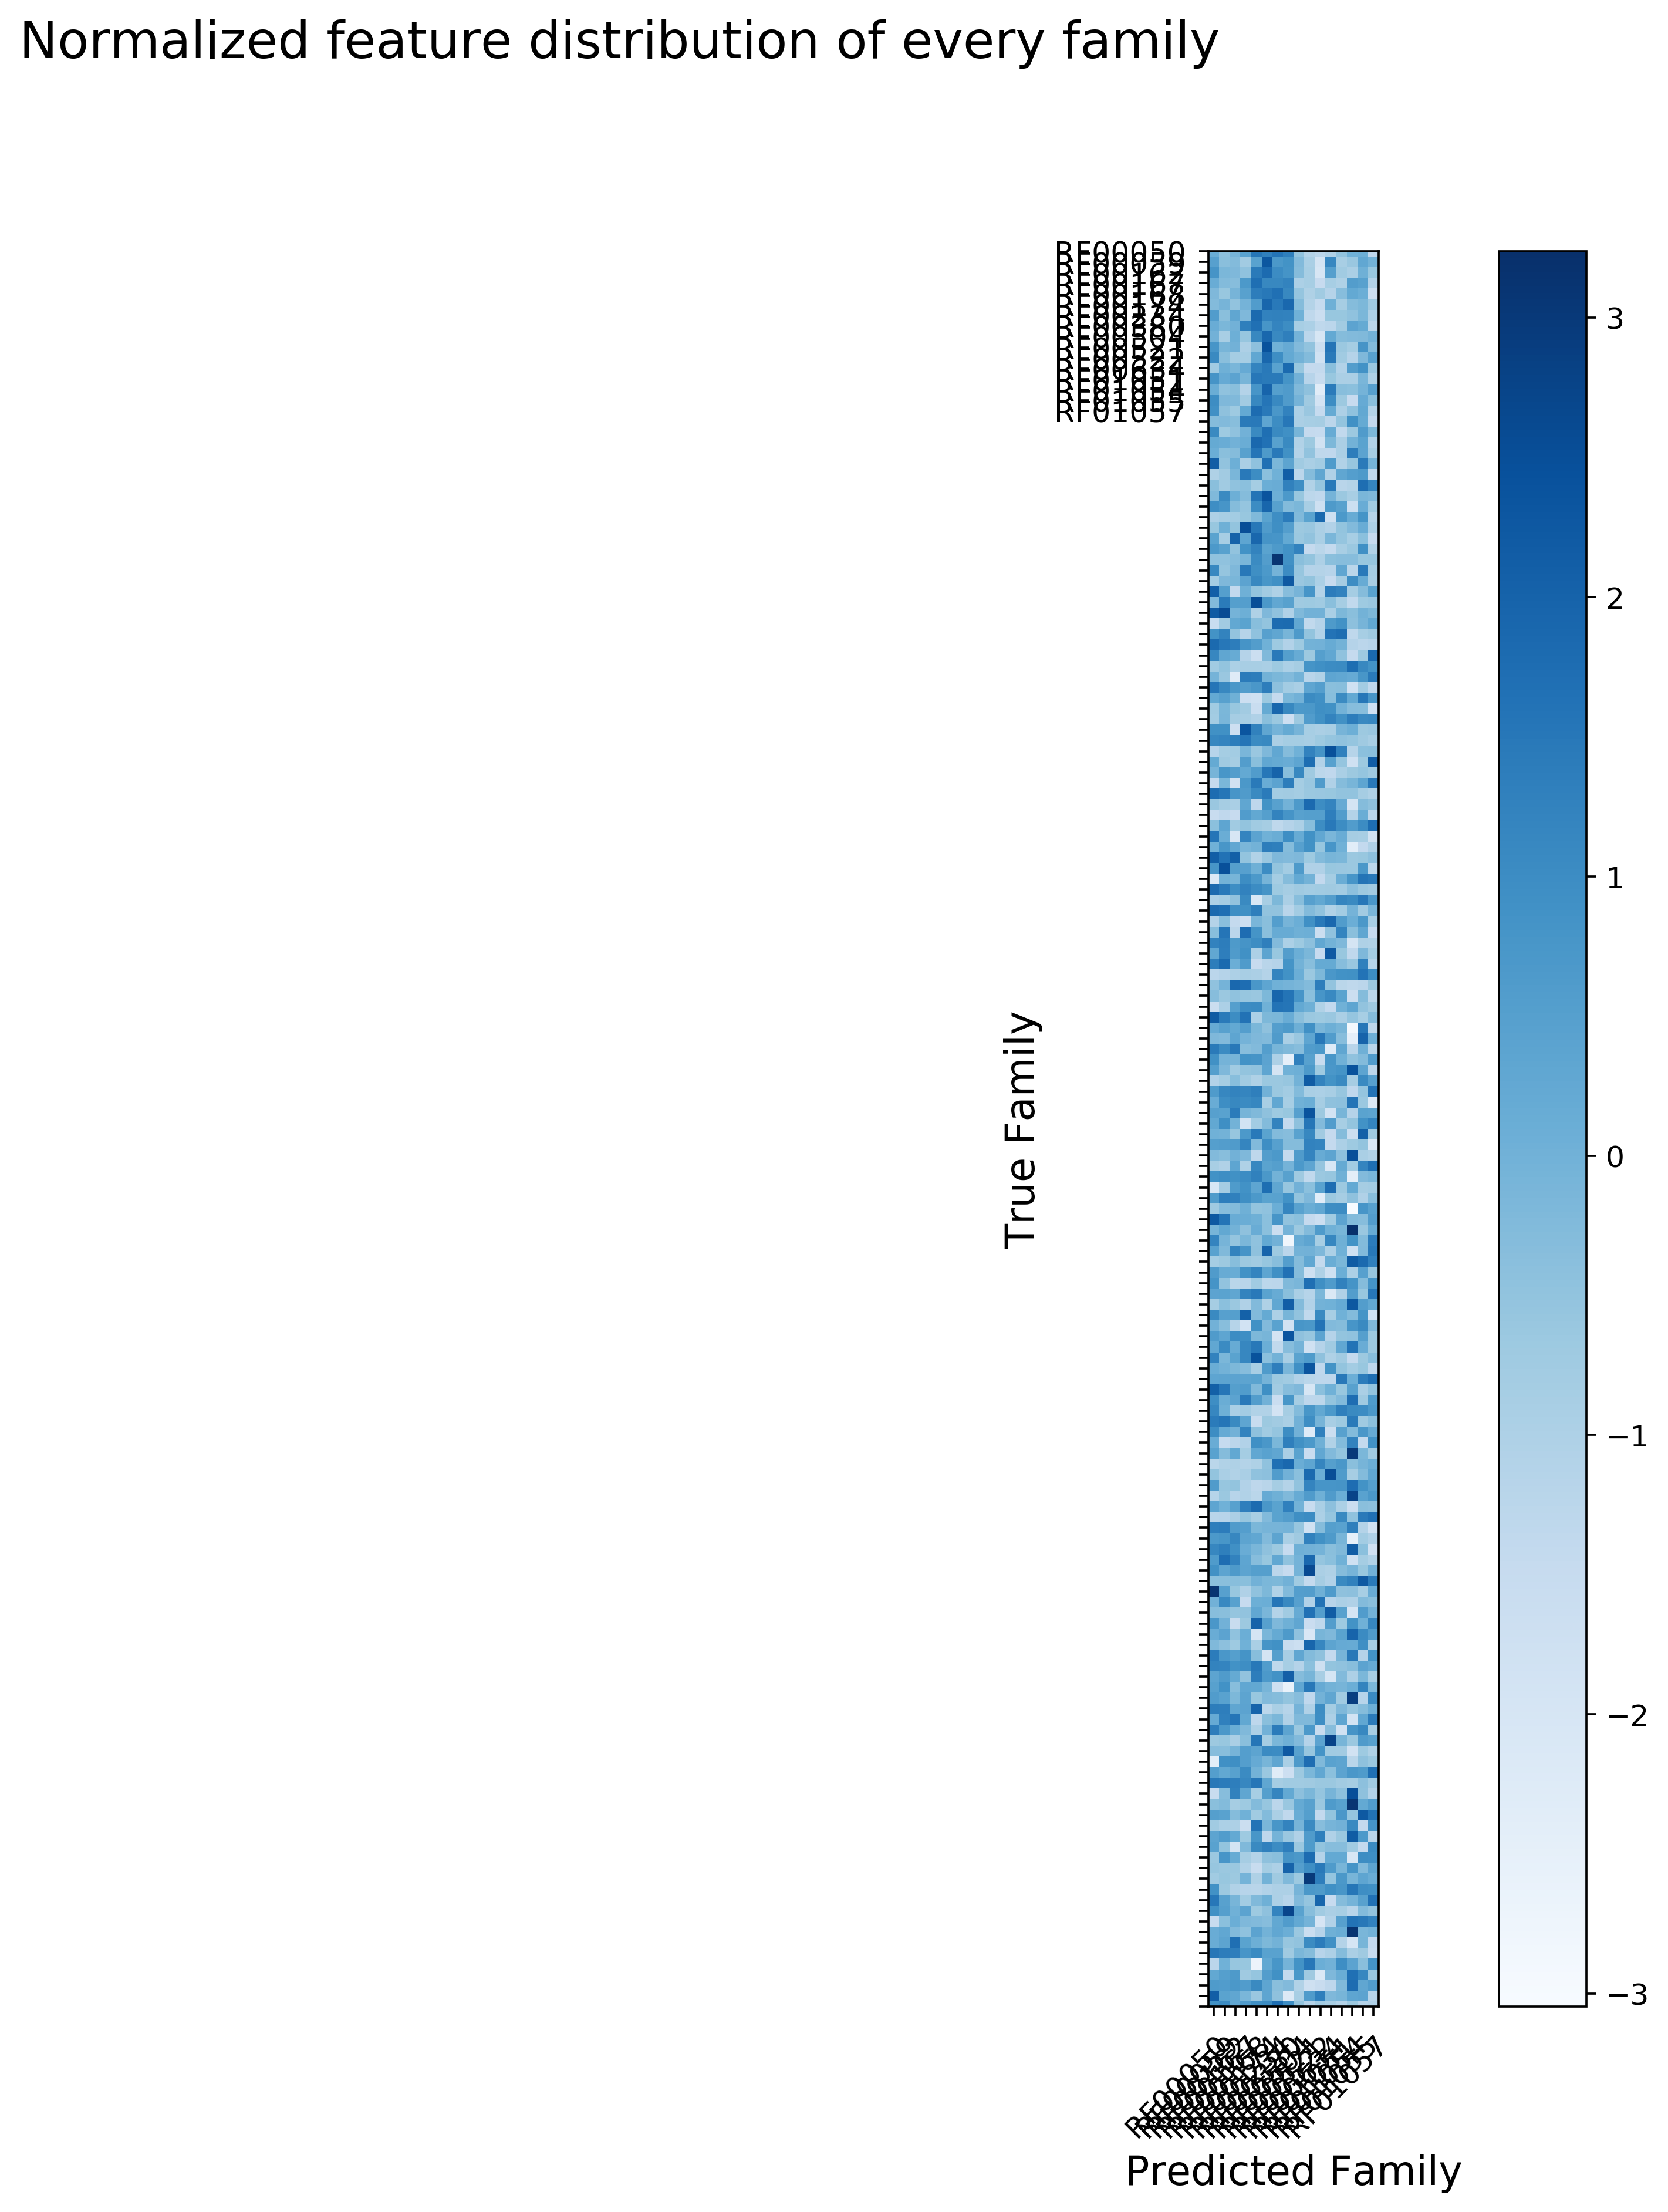

In [80]:
plot_feature_distribution_heatmap(heat_norm, label)

In [79]:
type(heat_norm)

pandas.core.frame.DataFrame

In [44]:
pltROC(knn, svm, random, gb, mlp, nb, balance = 'balanced', x_train, y_trian, x_test, y_test)
pltROC(knn, svm, random, gb, mlp, nb, balance = 'imbalanced', x_train, y_trian, x_test, y_test)

{'RF00050': 1672, 'RF00059': 2519, 'RF00162': 1758, 'RF00167': 1710, 'RF00168': 1205, 'RF00174': 3016, 'RF00234': 2000, 'RF00380': 1510, 'RF00504': 1481, 'RF00521': 1090, 'RF00522': 770, 'RF00634': 1490, 'RF01051': 1416, 'RF01054': 320, 'RF01055': 1105, 'RF01057': 1390}


## KNN model test

knn
----------------------------------------------------------------
6
{'fit_time': array([0.95336127, 0.99341369, 0.99704051, 1.02748179, 0.99035978,
       0.97832179, 1.00948763, 0.97577453, 0.97818041, 1.01272702]), 'score_time': array([16.3095305 , 16.71540999, 16.43894553, 16.68902254, 16.07044554,
       15.47572112, 16.735322  , 16.91454458, 15.68356133, 16.39482427]), 'test_acc': array([0.72870939, 0.69779736, 0.71869489, 0.69929453, 0.70723104,
       0.73897707, 0.72526502, 0.71971706, 0.7159292 , 0.71288889]), 'test_prec_macro': array([0.61253839, 0.59042798, 0.58057882, 0.57191708, 0.5949764 ,
       0.61723969, 0.58452011, 0.58289859, 0.58572631, 0.59370343]), 'test_rec_macro': array([0.78392326, 0.73330887, 0.7483615 , 0.74558523, 0.76692802,
       0.76934627, 0.76493584, 0.75168234, 0.78132279, 0.75193723]), 'test_f1_macro': array([0.66623734, 0.63418467, 0.63162997, 0.62366661, 0.64560651,
       0.66487538, 0.63547781, 0.63046406, 0.64307661, 0.63990146])}
8
{'fit_ti

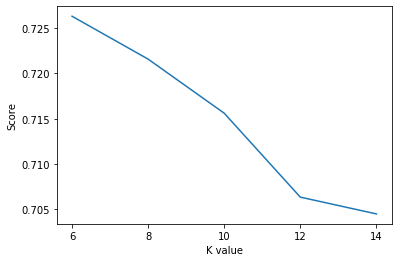

Maximum KNN Acuracy Score is 72.63%
f1 score of knn: 0.651
Classification report of knn: 
              precision    recall  f1-score   support

     RF00050      0.658     0.835     0.736       375
     RF00059      0.916     0.735     0.815      1097
     RF00162      0.570     0.729     0.640       362
     RF00167      0.621     0.761     0.684       243
     RF00168      0.285     0.700     0.405       100
     RF00174      0.974     0.643     0.775      1270
     RF00234      0.391     0.693     0.500        75
     RF00380      0.412     0.848     0.554        66
     RF00504      0.843     0.719     0.776       644
     RF00521      0.554     0.879     0.680        58
     RF00522      0.826     0.974     0.894        39
     RF00634      0.488     0.896     0.632        67
     RF01051      0.744     0.763     0.753       312
     RF01054      0.286     0.857     0.429         7
     RF01055      0.512     0.793     0.622        82
     RF01057      0.402     0.729     0.518  

In [13]:
print('knn')
print('----------------------------------------------------------------')
knn = KNN(x_train, y_train, x_test, y_test, 'not majority')


knn_im
----------------------------------------------------------------
6
{'fit_time': array([0.03998137, 0.03458619, 0.03464437, 0.03616953, 0.03397727,
       0.03545976, 0.03402114, 0.03683209, 0.03533435, 0.03428674]), 'score_time': array([3.6157577 , 3.54911852, 3.5718224 , 3.63954043, 3.52800703,
       3.4972887 , 3.44171381, 3.70664811, 3.50344896, 3.58219695]), 'test_acc': array([0.81474978, 0.79911894, 0.81922399, 0.80687831, 0.80070547,
       0.82716049, 0.82773852, 0.80725022, 0.81238938, 0.80088889]), 'test_prec_macro': array([0.78027162, 0.82015651, 0.73395955, 0.79898418, 0.7806436 ,
       0.83139505, 0.81865914, 0.74291728, 0.80410032, 0.72733841]), 'test_rec_macro': array([0.66525646, 0.67657094, 0.64266947, 0.67275181, 0.65919298,
       0.71583962, 0.6801095 , 0.63130963, 0.74717424, 0.61949818]), 'test_f1_macro': array([0.69766523, 0.72338063, 0.66751112, 0.71705622, 0.69379744,
       0.75466769, 0.72282596, 0.669877  , 0.76880207, 0.6537625 ])}
8
{'fit_time': ar

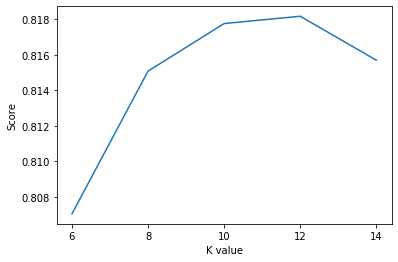

Maximum KNN_im Acuracy Score is 81.82%
f1 score of knn_im: 0.689
Classification report of knn_im: 
              precision    recall  f1-score   support

     RF00050      0.825     0.789     0.807       375
     RF00059      0.796     0.931     0.858      1097
     RF00162      0.710     0.677     0.693       362
     RF00167      0.822     0.724     0.770       243
     RF00168      0.648     0.460     0.538       100
     RF00174      0.863     0.901     0.881      1270
     RF00234      0.707     0.387     0.500        75
     RF00380      0.800     0.606     0.690        66
     RF00504      0.806     0.825     0.815       644
     RF00521      0.894     0.724     0.800        58
     RF00522      0.864     0.974     0.916        39
     RF00634      0.750     0.672     0.709        67
     RF01051      0.869     0.763     0.812       312
     RF01054      0.000     0.000     0.000         7
     RF01055      0.846     0.537     0.657        82
     RF01057      0.839     0.441   

In [14]:
print('knn_im')
print('----------------------------------------------------------------')
knn_im = KNN_im(x_train, y_train, x_test, y_test)

In [22]:
joblib.dump(knn_im, './Model/knn_im.pkl')

['./Model/knn_im.pkl']

## SVM model test

In [50]:
print('svm')
print('----------------------------------------------------------------')
svm = svm(x_train, y_train, x_test, y_test, 'not majority')
joblib.dump(knn, './Model/svm.pkl')

svm
----------------------------------------------------------------
poly
{'fit_time': array([926.44448948, 906.95392132, 895.62845874, 874.11024642,
       887.72135711, 905.40604734, 899.91600084, 929.89332342,
       890.50170326, 869.44520402]), 'score_time': array([10.03971696, 11.48535109, 11.80199742, 10.83742595, 11.89806509,
       11.6300149 , 10.74866629,  9.8872025 , 11.81904387, 10.83868265]), 'test_acc': array([0.08165057, 0.10044053, 0.09171076, 0.0952381 , 0.08818342,
       0.10758377, 0.10689046, 0.10167993, 0.09823009, 0.09066667]), 'test_prec_macro': array([0.13831756, 0.15065609, 0.142631  , 0.10912379, 0.12204192,
       0.14476205, 0.12275107, 0.18713181, 0.24005051, 0.10030325]), 'test_rec_macro': array([0.19104724, 0.21679401, 0.2637654 , 0.20981947, 0.21089163,
       0.28131217, 0.26202968, 0.2193208 , 0.25833886, 0.20017492]), 'test_f1_macro': array([0.06785395, 0.07029554, 0.07129347, 0.06011904, 0.06517048,
       0.07928024, 0.06925733, 0.07659582, 0.0759

['./Model/svm.pkl']

svm_im
----------------------------------------------------------------
poly
{'fit_time': array([31.53497624, 31.43073511, 33.3569026 , 32.05710936, 31.89295864,
       31.53926158, 31.21269155, 31.49792862, 31.35870171, 31.41485763]), 'score_time': array([2.53604889, 2.68690085, 2.25903606, 2.65796423, 2.66575146,
       2.68959022, 2.48976278, 2.69110799, 2.66564965, 2.50007486]), 'test_acc': array([0.41176471, 0.42290749, 0.42328042, 0.41798942, 0.41887125,
       0.42945326, 0.42402827, 0.43147657, 0.42743363, 0.43288889]), 'test_prec_macro': array([0.07189405, 0.07140786, 0.07299716, 0.07166875, 0.07148097,
       0.07119804, 0.07401514, 0.07128184, 0.0715747 , 0.07133786]), 'test_rec_macro': array([0.10724469, 0.10943906, 0.10964437, 0.1082384 , 0.10832216,
       0.11105198, 0.10980182, 0.11134182, 0.11038437, 0.11133787]), 'test_f1_macro': array([0.07694998, 0.0784728 , 0.07879828, 0.07771456, 0.07793875,
       0.07915703, 0.07927389, 0.07955168, 0.07891896, 0.0796178 ])}
rbf


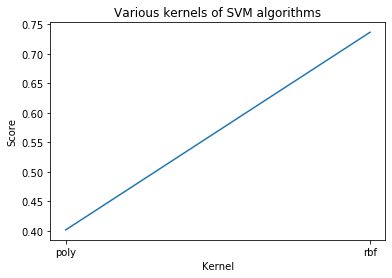

Maximum kernel Score is 73.68%
f1 score of svm_im: 0.326
Classification report of svm_im: 
              precision    recall  f1-score   support

     RF00050      0.799     0.712     0.753       375
     RF00059      0.755     0.933     0.835      1097
     RF00162      0.718     0.569     0.635       362
     RF00167      0.705     0.638     0.670       243
     RF00168      0.000     0.000     0.000       100
     RF00174      0.752     0.887     0.814      1270
     RF00234      1.000     0.013     0.026        75
     RF00380      0.000     0.000     0.000        66
     RF00504      0.686     0.888     0.774       644
     RF00521      0.000     0.000     0.000        58
     RF00522      0.000     0.000     0.000        39
     RF00634      0.000     0.000     0.000        67
     RF01051      0.695     0.724     0.710       312
     RF01054      0.000     0.000     0.000         7
     RF01055      0.000     0.000     0.000        82
     RF01057      0.000     0.000     0.000 

['./Model/svm_im.pkl']

In [51]:
print('svm_im')
print('----------------------------------------------------------------')
svm_im = svm_im(x_train, y_train, x_test, y_test)
joblib.dump(knn, './Model/svm_im.pkl')

## Random forest test

In [15]:
print('random forest')
print('----------------------------------------------------------------')
random = random_forest(x_train, y_train, x_test, y_test, dict)

random forest
----------------------------------------------------------------
Test score: 0.86
f1 score of random_forest: 0.817
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.840     0.811     0.825       375
     RF00059      0.852     0.934     0.891      1097
     RF00162      0.796     0.710     0.750       362
     RF00167      0.850     0.819     0.834       243
     RF00168      0.771     0.640     0.699       100
     RF00174      0.895     0.904     0.899      1270
     RF00234      0.727     0.747     0.737        75
     RF00380      0.904     0.712     0.797        66
     RF00504      0.866     0.854     0.860       644
     RF00521      0.964     0.931     0.947        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.818     0.806     0.812        67
     RF01051      0.890     0.856     0.873       312
     RF01054      0.800     0.571     0.667         7
     RF01055      0

In [23]:
joblib.dump(knn, './Model/random.pkl')

['./Model/random.pkl']

In [16]:
print('random_forest_im')
print('----------------------------------------------------------------')
random_im = random_forest_im(x_train, y_train, x_test, y_test)

random_forest_im
----------------------------------------------------------------
Test score: 0.84
f1 score of random_forest_im: 0.759
Classification report of random_forest_im: 
              precision    recall  f1-score   support

     RF00050      0.835     0.797     0.816       375
     RF00059      0.828     0.943     0.882      1097
     RF00162      0.828     0.677     0.745       362
     RF00167      0.855     0.802     0.828       243
     RF00168      0.768     0.530     0.627       100
     RF00174      0.859     0.920     0.888      1270
     RF00234      0.740     0.493     0.592        75
     RF00380      0.912     0.470     0.620        66
     RF00504      0.833     0.884     0.858       644
     RF00521      0.959     0.810     0.879        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.900     0.672     0.769        67
     RF01051      0.886     0.824     0.854       312
     RF01054      1.000     0.286     0.444         7
     RF010

In [24]:
joblib.dump(random_im, './Model/random_im.pkl')

['./Model/random_im.pkl']

## Gradient Boosting

In [48]:
gb = gradient_boosting(x_train, y_train, x_test, y_test, dict)
joblib.dump(knn, './Model/gb.pkl')

Accuracy on test set:0.826
f1 score of gb: 0.717
Classification report of gb: 
              precision    recall  f1-score   support

     RF00050      0.791     0.779     0.785       375
     RF00059      0.852     0.912     0.881      1097
     RF00162      0.757     0.696     0.725       362
     RF00167      0.830     0.745     0.785       243
     RF00168      0.533     0.480     0.505       100
     RF00174      0.887     0.899     0.893      1270
     RF00234      0.538     0.667     0.595        75
     RF00380      0.809     0.576     0.673        66
     RF00504      0.845     0.835     0.840       644
     RF00521      0.878     0.621     0.727        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.672     0.672     0.672        67
     RF01051      0.819     0.827     0.823       312
     RF01054      0.222     0.286     0.250         7
     RF01055      0.637     0.622     0.630        82
     RF01057      0.732     0.695     0.713        59

 

['./Model/gb.pkl']

In [49]:
gb_im = gradient_boosting_im(x_train, y_train, x_test, y_test)
joblib.dump(knn, './Model/gb_im.pkl')

Accuracy on train set:0.814
Accuracy on test set:0.814
f1 score of gb_im: 0.682
Classification report of gb_im: 
              precision    recall  f1-score   support

     RF00050      0.824     0.739     0.779       375
     RF00059      0.827     0.912     0.868      1097
     RF00162      0.732     0.710     0.721       362
     RF00167      0.767     0.691     0.727       243
     RF00168      0.643     0.450     0.529       100
     RF00174      0.865     0.906     0.885      1270
     RF00234      0.729     0.573     0.642        75
     RF00380      0.721     0.470     0.569        66
     RF00504      0.794     0.857     0.824       644
     RF00521      0.804     0.638     0.712        58
     RF00522      0.971     0.872     0.919        39
     RF00634      0.684     0.582     0.629        67
     RF01051      0.854     0.769     0.809       312
     RF01054      0.053     0.143     0.077         7
     RF01055      0.742     0.561     0.639        82
     RF01057      0.68

['./Model/gb_im.pkl']

## MLP

In [40]:
mlp = mlp(x_train, y_train, x_test, y_test, dict)

Iteration 1, loss = 1.96512139
Iteration 2, loss = 0.96943367
Iteration 3, loss = 0.71323499
Iteration 4, loss = 0.59560001
Iteration 5, loss = 0.52411311
Iteration 6, loss = 0.47951746
Iteration 7, loss = 0.44550452
Iteration 8, loss = 0.41990934
Iteration 9, loss = 0.39888880
Iteration 10, loss = 0.37818923
Iteration 11, loss = 0.36571090
Iteration 12, loss = 0.35146224
Iteration 13, loss = 0.33777847
Iteration 14, loss = 0.32694041
Iteration 15, loss = 0.32077138
Iteration 16, loss = 0.31042069
Iteration 17, loss = 0.30394738
Iteration 18, loss = 0.29815481
Iteration 19, loss = 0.29264803
Iteration 20, loss = 0.28384229
Iteration 21, loss = 0.28183641
Iteration 22, loss = 0.27237093
Iteration 23, loss = 0.27066782
Iteration 24, loss = 0.26628681
Iteration 25, loss = 0.26059930
Iteration 26, loss = 0.25267927
Iteration 27, loss = 0.25218027
Iteration 28, loss = 0.25043795
Iteration 29, loss = 0.24270072
Iteration 30, loss = 0.23977493
Iteration 31, loss = 0.23498557
Iteration 32, los

In [42]:
joblib.dump(knn, './Model/mlp.pkl')

['./Model/mlp.pkl']

In [41]:
mlp_im = mlp_im(x_train, y_train, x_test, y_test)

Iteration 1, loss = 2.05757597
Iteration 2, loss = 1.40100397
Iteration 3, loss = 1.06682090
Iteration 4, loss = 0.90918788
Iteration 5, loss = 0.81202087
Iteration 6, loss = 0.74952346
Iteration 7, loss = 0.70394352
Iteration 8, loss = 0.66260693
Iteration 9, loss = 0.62626680
Iteration 10, loss = 0.60285968
Iteration 11, loss = 0.57733616
Iteration 12, loss = 0.55984352
Iteration 13, loss = 0.53899421
Iteration 14, loss = 0.52904034
Iteration 15, loss = 0.51268833
Iteration 16, loss = 0.50329313
Iteration 17, loss = 0.49878911
Iteration 18, loss = 0.47963397
Iteration 19, loss = 0.47618938
Iteration 20, loss = 0.46859914
Iteration 21, loss = 0.46057647
Iteration 22, loss = 0.45521722
Iteration 23, loss = 0.45019211
Iteration 24, loss = 0.44238611
Iteration 25, loss = 0.43966701
Iteration 26, loss = 0.43283508
Iteration 27, loss = 0.43245992
Iteration 28, loss = 0.42409877
Iteration 29, loss = 0.41775710
Iteration 30, loss = 0.41382327
Iteration 31, loss = 0.40984272
Iteration 32, los

In [43]:
joblib.dump(knn, './Model/mlp_im.pkl')

['./Model/mlp_im.pkl']

In [ ]:
print_report('mlp_im_test', mlp_im, x_train, y_train)

## NB test

In [44]:
print('nb')
print('-------------------------------------------------------')
nb = naive_bayes(x_train, y_train, x_test, y_test, dict)

nb
-------------------------------------------------------
Accuracy of Naive Bayes: 65.20%
f1 score of nb: 0.578
Classification report of nb: 
              precision    recall  f1-score   support

     RF00050      0.653     0.621     0.637       375
     RF00059      0.906     0.674     0.773      1097
     RF00162      0.568     0.638     0.601       362
     RF00167      0.480     0.580     0.525       243
     RF00168      0.248     0.760     0.373       100
     RF00174      0.862     0.639     0.734      1270
     RF00234      0.270     0.547     0.361        75
     RF00380      0.435     0.712     0.540        66
     RF00504      0.746     0.561     0.640       644
     RF00521      0.922     0.810     0.862        58
     RF00522      0.860     0.949     0.902        39
     RF00634      0.302     0.776     0.435        67
     RF01051      0.626     0.798     0.701       312
     RF01054      0.161     0.714     0.263         7
     RF01055      0.468     0.634     0.539   

In [45]:
joblib.dump(knn, './Model/nb.pkl')

['./Model/nb.pkl']

In [46]:
print('nb_im')
print('-------------------------------------------------------')
nb_im = naive_bayes_im(x_train, y_train, x_test, y_test)

nb_im
-------------------------------------------------------
Accuracy of Naive Bayes: 65.59%
f1 score of nb_im: 0.574
Classification report of nb_im: 
              precision    recall  f1-score   support

     RF00050      0.641     0.619     0.630       375
     RF00059      0.889     0.700     0.783      1097
     RF00162      0.571     0.610     0.590       362
     RF00167      0.529     0.523     0.526       243
     RF00168      0.238     0.770     0.364       100
     RF00174      0.875     0.643     0.741      1270
     RF00234      0.319     0.387     0.349        75
     RF00380      0.443     0.773     0.564        66
     RF00504      0.749     0.565     0.644       644
     RF00521      0.814     0.828     0.821        58
     RF00522      0.841     0.949     0.892        39
     RF00634      0.271     0.806     0.406        67
     RF01051      0.614     0.817     0.702       312
     RF01054      0.123     1.000     0.219         7
     RF01055      0.509     0.671    

In [47]:
joblib.dump(knn, './Model/nb_im.pkl')

['./Model/nb_im.pkl']

## Three methods comparison

In [168]:
best = make_pipeline(SMOTE(random_state = 5), KNeighborsClassifier(n_neighbors=10))
scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores)
best.fit(x_train, y_train)
best.score(x_test, y_test)
best_pred = best.predict(x_test)
# f1 score
print("f1 score of best: {:.2f}".format(f1_score(y_test,best_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best: \n{}".format(classification_report(y_test, best_pred,
                                        target_names= label)))
best_proba = best.predict_proba(x_test)

{'fit_time': array([1.36815619, 1.38522267, 1.27516413, 1.46671844, 1.39341235]), 'score_time': array([65.77883387, 66.15830994, 64.95893312, 67.77423406, 66.04027724]), 'test_precision_macro': array([0.45819163, 0.48098308, 0.45682151, 0.47233651, 0.47222897]), 'test_recall_macro': array([0.69405591, 0.69335485, 0.67254681, 0.7193012 , 0.69062105]), 'test_f1_macro': array([0.46983322, 0.4947362 , 0.46601983, 0.49063489, 0.4851479 ])}
f1 score of best: 0.50
Classification report of best: 
              precision    recall  f1-score   support

     RF00050       0.62      0.79      0.69       359
     RF00059       0.95      0.43      0.59      1083
     RF00162       0.44      0.80      0.57       365
     RF00167       0.54      0.73      0.62       244
     RF00168       0.14      0.66      0.23        88
     RF00174       1.00      0.33      0.49      1277
     RF00234       0.25      0.71      0.37        90
     RF00380       0.20      0.79      0.32        63
     RF00504       

In [170]:
best2 = KNeighborsClassifier(n_neighbors=16)
scores2 = cross_validate(best2, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores2)
best2.fit(x_train, y_train)
best2.score(x_test, y_test)
best2_pred = best2.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best2_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best2: \n{}".format(classification_report(y_test, best2_pred,
                                        target_names= label)))
best2_proba = best2.predict_proba(x_test)

{'fit_time': array([0.04368973, 0.04368138, 0.04063821, 0.04307175, 0.04468369]), 'score_time': array([11.63832211, 11.69619298, 12.09875536, 11.89288187, 11.96761632]), 'test_precision_macro': array([0.76222982, 0.77800996, 0.71748333, 0.7782801 , 0.79469287]), 'test_recall_macro': array([0.51248768, 0.5246983 , 0.50299728, 0.52320519, 0.49453976]), 'test_f1_macro': array([0.5736022 , 0.57565019, 0.55515465, 0.5859372 , 0.55578544])}
f1 score of best3: 0.60
Classification report of best2: 
              precision    recall  f1-score   support

     RF00050       0.83      0.78      0.81       359
     RF00059       0.79      0.92      0.85      1083
     RF00162       0.65      0.74      0.69       365
     RF00167       0.86      0.59      0.70       244
     RF00168       0.57      0.48      0.52        88
     RF00174       0.88      0.87      0.88      1277
     RF00234       0.80      0.27      0.40        90
     RF00380       0.79      0.48      0.59        63
     RF00504     

In [171]:
over_samples_train = SMOTEENN(random_state=5, n_jobs=5)
x_train_s, y_train_s = over_samples_train.fit_sample(x_train, y_train)
best3 = KNeighborsClassifier(n_neighbors=16)
scores3 = cross_validate(best3, x_train_s, y_train_s, scoring = scoring, cv = 5, n_jobs=10)
print(scores3)
best3.fit(x_train_s, y_train_s)
best3.score(x_test, y_test)

best3_pred = best3.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best3_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best3: \n{}".format(classification_report(y_test, best3_pred,
                                        target_names= label)))
best3_proba = best3.predict_proba(x_test)

{'fit_time': array([0.22312522, 0.29851818, 0.29342937, 0.18135238, 0.28857732]), 'score_time': array([168.14797163, 165.46073842, 166.19052601, 162.7279706 ,
       163.33171201]), 'test_precision_macro': array([0.95304545, 0.96063604, 0.95937588, 0.9568318 , 0.95625031]), 'test_recall_macro': array([0.91273627, 0.92393875, 0.91939974, 0.90468659, 0.90314451]), 'test_f1_macro': array([0.92442428, 0.93549652, 0.93110554, 0.91621002, 0.91123336])}
f1 score of best3: 0.46
Classification report of best3: 
              precision    recall  f1-score   support

     RF00050       0.55      0.79      0.65       359
     RF00059       0.98      0.26      0.41      1083
     RF00162       0.40      0.80      0.53       365
     RF00167       0.50      0.72      0.59       244
     RF00168       0.11      0.66      0.19        88
     RF00174       1.00      0.17      0.30      1277
     RF00234       0.24      0.73      0.36        90
     RF00380       0.17      0.78      0.28        63
     

,A,C,G,U,AA,AC,AG,AU,CA,CC,...,GCUGAG,GCCACU,GCCUCC,GCCGAA,GGAAGG,GGAGAG,GGCUGA,GGCGGU,GGGAAG,GGGUGC
Class,,,,,,,,,,,,,,,,,,,,,
RF00522,0.11,0.047619,0.008929,0.072165,0.166667,0.086957,0.028571,0.129032,0.100000,0.064516,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00167,0.23,0.085714,0.169643,0.288660,0.194444,0.130435,0.142857,0.322581,0.066667,0.096774,...,0.0,0.0,0.000000,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0
RF00174,0.36,0.571429,0.491071,0.257732,0.250000,0.652174,0.342857,0.161290,0.333333,0.677419,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF01055,0.23,0.238095,0.303571,0.185567,0.194444,0.347826,0.200000,0.161290,0.166667,0.258065,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00059,0.22,0.114286,0.178571,0.195876,0.194444,0.217391,0.228571,0.161290,0.133333,0.096774,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF00059,0.23,0.257143,0.258929,0.278351,0.111111,0.391304,0.228571,0.258065,0.200000,0.258065,...,0.0,0.0,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00167,0.11,0.085714,0.080357,0.154639,0.138889,0.217391,0.000000,0.161290,0.066667,0.161290,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00059,0.10,0.180952,0.267857,0.164948,0.055556,0.130435,0.257143,0.064516,0.066667,0.225806,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.5
